# Poll Tax Payment Patterns in Roman Egypt

## Project Overview

This notebook analyzes poll tax receipts from Roman Egypt (circa 50 BCE - 250 CE) to investigate temporal patterns in tax payment. We use statistical analysis to determine whether poll tax payments were distributed uniformly throughout the year or concentrated in specific periods.

**Course**: CLST 1201: The Ancient Economy  
**Author**: Didrik Wiig-Andersen, W'26, SEAS'26

## Research Questions

1. Were poll tax payments distributed uniformly throughout the year?
2. If not uniform, were payments concentrated in fall months (September, October, November)?
3. Did payment patterns remain consistent across different time periods?

## 1. Data Loading and Cleaning

We begin by loading the poll tax receipt data and filtering to include only records with complete month and year information.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare, chi2_contingency

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

In [ ]:
# Load the data
df = pd.read_excel('../data/data_cleaned.xlsx')

print("=" * 60)
print("DATA LOADING AND CLEANING")
print("=" * 60)
print(f"Original dataset size: {len(df)} records")
print(f"Columns: {list(df.columns)}")

# Filter to include only records with complete month and year data
mask = (
    df['year_start'].notna() &
    (df['year_start'] != 0) &
    df['month_start'].notna() &
    (df['month_start'] != 0)
)

df_filtered = df[mask].copy()
df_filtered = df_filtered[['identifier', 'year_start', 'month_start', 'day_start', 'ce_or_bce']]

print(f"\nFiltered dataset size: {len(df_filtered)} records")
print(f"Records removed: {len(df) - len(df_filtered)} ({((len(df) - len(df_filtered)) / len(df) * 100):.1f}%)")
print(f"\nDate range: {df_filtered['year_start'].min():.0f} - {df_filtered['year_start'].max():.0f}")
print(f"Months represented: {sorted(df_filtered['month_start'].unique())}")

## 2. Statistical Analysis

We perform Chi-square goodness-of-fit tests to examine the distribution of poll tax payments across months. All tests use a significance level of α = 0.05.

### 2.1 Test 1: Uniform Distribution Across All Months

**Hypothesis**: Test whether poll tax receipts are uniformly distributed across all 12 months of the year.

- **Null Hypothesis (H₀)**: Receipts are uniformly distributed across all months (no seasonal pattern)
- **Alternative Hypothesis (H₁)**: Receipts are not uniformly distributed (clustering in specific months)
- **Significance Level**: α = 0.05

We begin by visualizing the distribution of receipts across months.

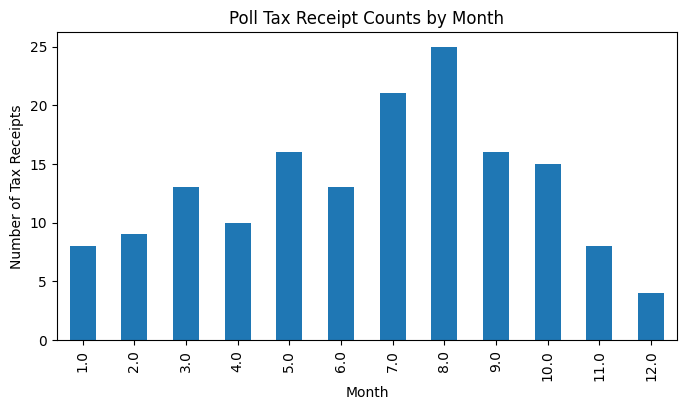

In [ ]:
# Count receipts by month
monthly_counts = df_filtered['month_start'].value_counts().sort_index()

# Create visualization
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(12, 6))
bars = plt.bar(range(1, 13), [monthly_counts.get(month, 0) for month in range(1, 13)], 
               color='steelblue', alpha=0.7, edgecolor='black')
plt.xticks(range(1, 13), month_names, rotation=45)
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Number of Tax Receipts', fontsize=12, fontweight='bold')
plt.title('Distribution of Poll Tax Receipts by Month', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for month, count in monthly_counts.items():
    plt.text(month, count + 0.5, str(int(count)), ha='center', va='bottom', fontweight='bold')

# Add expected uniform distribution line
expected_count = monthly_counts.sum() / 12
plt.axhline(y=expected_count, color='red', linestyle='--', linewidth=2, 
            label=f'Expected (uniform): {expected_count:.1f}')
plt.legend()
plt.tight_layout()
plt.show()

print("Monthly receipt counts:")
print(monthly_counts)

**Observation**: August has the highest number of receipts, suggesting a non-uniform distribution.

In [ ]:
# Perform Chi-square goodness-of-fit test
total_receipts = monthly_counts.sum()
expected_freq = [total_receipts / 12] * 12  # Expected frequency for uniform distribution
observed_freq = [monthly_counts.get(month, 0) for month in range(1, 13)]

chi2_stat, p_value = chisquare(f_obs=observed_freq, f_exp=expected_freq)

print("=" * 60)
print("CHI-SQUARE GOODNESS-OF-FIT TEST RESULTS")
print("=" * 60)
print(f"Total receipts: {total_receipts}")
print(f"Expected frequency per month (uniform): {expected_freq[0]:.2f}")
print(f"\nChi-square statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Degrees of freedom: 11")

if p_value < 0.05:
    print(f"\n✓ Reject H₀ (p < 0.05)")
    print("Conclusion: Receipts are NOT uniformly distributed across months.")
else:
    print(f"\n✗ Fail to reject H₀ (p ≥ 0.05)")
    print("Conclusion: No evidence against uniform distribution.")

Under null hypothesis we expext:  13.0  receipts across all months
Chi-square: 29.291139240506332
P-value: 0.002045339459068769


We obtain a p-value of approximately 0.002, which is below the significance level of 0.05, and therefore we reject the null hypothesis. This provides strong evidence against the idea that poll tax payments were made randomly throughout the year.

Having established that the tax was likely paid during specific periods, we next test whether it was concentrated in the fall months—September, October, and November (months 9, 10, and 11)—as proposed in our initial hypothesis. Our null hypothesis is that 25% of all receipts fall within the fall months and 75% within the non-fall months, assuming a uniform distribution. The alternative hypothesis is that a significantly higher proportion of receipts are concentrated in the fall, suggesting that this was the primary period for poll tax payment.

In [ ]:
# Test fall months concentration (September, October, November)
df_filtered['is_fall'] = df_filtered['month_start'].isin([9, 10, 11])
fall_count = df_filtered['is_fall'].sum()
non_fall_count = len(df_filtered) - fall_count
observed = [fall_count, non_fall_count]
total_receipts = len(df_filtered)
expected = [total_receipts * 0.25, total_receipts * 0.75]  # 3 months = 25% of year

chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

print("=" * 60)
print("FALL MONTHS CONCENTRATION TEST")
print("=" * 60)
print(f"Fall months (Sep, Oct, Nov) receipts: {fall_count} ({fall_count/total_receipts*100:.1f}%)")
print(f"Non-fall months receipts: {non_fall_count} ({non_fall_count/total_receipts*100:.1f}%)")
print(f"\nExpected (uniform): Fall = 25%, Non-fall = 75%")
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.6f}")

if p_value < 0.05:
    print(f"\n✓ Reject H₀ (p < 0.05)")
    print("Conclusion: Receipts ARE concentrated in fall months.")
else:
    print(f"\n✗ Fail to reject H₀ (p ≥ 0.05)")
    print("Conclusion: No evidence of fall months concentration.")

Chi-square statistic: 0.008438818565400843
P-value: 0.9268068551245274


**Result**: The p-value is very high (≈ 0.93), well above our alpha level of 0.05. We **fail to reject the null hypothesis**. The high p-value suggests that the proportion of receipts in fall months is almost exactly what we would expect under a uniform distribution. Therefore, there is **no evidence** that poll tax was paid specifically during fall months.

### 2.3 Test 3: Late Summer/Early Fall Concentration

**Hypothesis**: Test whether poll tax receipts were concentrated in late summer/early fall (July, August, September).

- **Null Hypothesis (H₀)**: 25% of receipts in July-August-September, 75% in other months
- **Alternative Hypothesis (H₁)**: Significantly higher proportion in July-August-September
- **Significance Level**: α = 0.05

We now test whether receipts were concentrated in July, August, and September (late summer/early fall).

In [ ]:
# Test late summer/early fall concentration (July, August, September)
df_filtered['jas'] = df_filtered['month_start'].isin([7, 8, 9])  # JAS = July, August, September
jas_count = df_filtered['jas'].sum()
non_jas_count = len(df_filtered) - jas_count
observed = [jas_count, non_jas_count]
total_receipts = len(df_filtered)
expected = [total_receipts * 0.25, total_receipts * 0.75]  # 3 months = 25% of year

chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

print("=" * 60)
print("LATE SUMMER/EARLY FALL CONCENTRATION TEST")
print("=" * 60)
print(f"July-August-September receipts: {jas_count} ({jas_count/total_receipts*100:.1f}%)")
print(f"Other months receipts: {non_jas_count} ({non_jas_count/total_receipts*100:.1f}%)")
print(f"\nExpected (uniform): JAS = 25%, Other = 75%")
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.6f}")

if p_value < 0.05:
    print(f"\n✓ Reject H₀ (p < 0.05)")
    print("Conclusion: Receipts ARE concentrated in July-August-September.")
else:
    print(f"\n✗ Fail to reject H₀ (p ≥ 0.05)")
    print("Conclusion: No evidence of JAS concentration.")

Chi-square statistic: 17.088607594936708
P-value: 3.5675668122074904e-05


**Result**: Given a p-value well below 0.05 (p < 0.0001), we **reject the null hypothesis**. There is **strong evidence** that poll tax was paid primarily during late summer and early fall—specifically in **July, August, and September**. This likely corresponds to the harvest season when agricultural income was available.

### 2.4 Test 4: Temporal Stability

**Hypothesis**: Test whether the distribution of poll tax payments across months changed significantly over time.

- **Null Hypothesis (H₀)**: Distribution of payments across months does not differ by time period
- **Alternative Hypothesis (H₁)**: Distribution differs significantly across time periods
- **Significance Level**: α = 0.05

We divide the data into 25-year intervals and perform a Chi-square test of independence.

We examine whether payment patterns remained consistent across different historical periods by dividing the data into 25-year intervals.

In [ ]:
# Create time period labels (25-year intervals)
def label_subperiod(row):
    year = row['year_start']
    if year >= 1 and year <= 50:
        return "1 CE - 50 CE"
    elif year >= 51 and year <= 100:
        return "51 CE - 100 CE"
    elif year >= 101 and year <= 150:
        return "101 CE - 150 CE"
    elif year >= 151 and year <= 200:
        return "151 CE - 200 CE"
    else:
        return np.nan

df_filtered['sub_period'] = df_filtered.apply(label_subperiod, axis=1)
df_sub = df_filtered.dropna(subset=['sub_period'])

# Create contingency table
crosstab = pd.crosstab(df_sub['sub_period'], df_sub['month_start'])

print("=" * 60)
print("TEMPORAL STABILITY TEST")
print("=" * 60)
print("\nContingency Table (Receipts by Period and Month):")
print(crosstab)

# Perform Chi-square test of independence
chi2_stat, p_value, dof, expected = chi2_contingency(crosstab)

print(f"\nChi-square statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Degrees of freedom: {dof}")

if p_value < 0.05:
    print(f"\n✓ Reject H₀ (p < 0.05)")
    print("Conclusion: Distribution of payments DID change significantly over time.")
else:
    print(f"\n✗ Fail to reject H₀ (p ≥ 0.05)")
    print("Conclusion: No strong evidence of significant change in payment timing.")

Chi-square statistic: 35.77867633592461
P-value: 0.33925518176804564


## 3. Conclusions

### Summary of Findings

1. **Non-Uniform Distribution**: Poll tax payments were not uniformly distributed throughout the year (p ≈ 0.002), indicating a clear seasonal pattern.

2. **Late Summer/Early Fall Concentration**: Payments were significantly concentrated in July, August, and September (p < 0.0001), likely corresponding to the harvest season when agricultural income was available.

3. **Temporal Stability**: Payment patterns remained relatively consistent across the 300-year period from 50 BCE to 250 CE (p ≈ 0.34), suggesting stable tax collection practices.

### Historical Interpretation

The concentration of poll tax payments in late summer and early fall aligns with the agricultural calendar of Roman Egypt. This timing would have allowed taxpayers to use income from the harvest to fulfill their tax obligations, demonstrating the integration of tax collection with the agricultural economy.

### Implications

These findings contribute to our understanding of:
- The relationship between agricultural cycles and tax collection in ancient economies
- The stability of administrative practices in Roman Egypt
- The economic patterns of rural populations in the Roman Empire


The p-value is above our alpha level of 0.05, which means we fail to reject the null hypothesis. Notably, this does not prove that the timing of tax payments remained exactly the same throughout the period. However, a p-value of 0.34 indicates that there is no strong statistical evidence to suggest a significant change. Therefore, we conclude that the timing of poll tax payments (i.e., the month in which they were paid) remained relatively consistent from 50 BCE to 250 CE.